In [3]:
# Import libraries
import numpy as np
import os , csv
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.interpolate import interp1d
from sklearn.decomposition import TruncatedSVD

In [26]:
path= '/media/maria/DATA1/Documents/NeuroMatchAcademy2020_dat/unzipped_files'
# Taken from https://github.com/MouseLand/steinmetz2019_NMA/blob/master/steinmetz_loader.py
# To obtain brain regions
def get_good_cells(fdirpath): #
    # location in brain of each neuron
    brain_loc = os.path.join(fdirpath, "channels.brainLocation.tsv")

    good_cells = (np.load(os.path.join(fdirpath, "clusters._phy_annotation.npy")) >= 2 ).flatten()
    clust_channel = np.load(os.path.join(fdirpath, "clusters.peakChannel.npy")).astype(int) - 1
    br = []
    with open(brain_loc, 'r') as tsv:
        tsvin = csv.reader(tsv, delimiter="\t")
        k=0
        for row in tsvin:
            if k>0:
                br.append(row[-1])
            k+=1
    br = np.array(br)
    good_cells = np.logical_and(good_cells, clust_channel.flatten()<len(br))
    brain_region = br[clust_channel[:,0]]


    return good_cells, brain_region, br

# Bin cells according to input bin size

def latency_coding(spike_times,trials_intervals, clusters_annotation,spike_clusters,bin_size = 100):
    
    # Using clusters._phy_annotation.npy obtain valid clusters (i.e. >= 2)
    valid_clusters_idx = np.array(np.where(clusters_annotation>=2))[0]

    spike_time_cells = np.empty(len(valid_clusters_idx), dtype=object) # Initalise empty object
    for i,cell_idx in enumerate(valid_clusters_idx):
      # Create a spike time arrays, where each array in the array is a spike time of a cell
      spike_time_cells[i] = spike_times[(np.where(spike_clusters == cell_idx)[0])]

    #print(spike_time_cells)
    #print(spike_time_cells[0].shape)
    #print(spike_time_cells[1].shape)
    
    first_spike_arr=[]
    for neuron in range(spike_time_cells.shape[0]):
        spk_tms_one_neuron=spike_time_cells[neuron]
        #print(spk_tms_one_neuron)
        first_spike_arr_trial=[]
        for trial_index in range(trials_intervals.shape[0]):
            #print(trials_intervals)
            spks_range = np.bitwise_and(spk_tms_one_neuron>=trials_intervals[trial_index][0],spk_tms_one_neuron<=trials_intervals[trial_index][1])
            #print(spks_range)
            spk_lst=list(spk_tms_one_neuron[spks_range])
            if not spk_lst:
                spk=100000
            else:
                spk=np.sort(spk_lst)[0]
                spk=spk-trials_intervals[trial_index][0]
            first_spike_arr_trial.append(spk)
        first_spike_arr.append(first_spike_arr_trial)
            
    return np.array(first_spike_arr).T

def logistic_regr_spike_lat(first_spike_arr,trials_response_choice):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(first_spike_arr, trials_response_choice, test_size=0.33, random_state=42)
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(random_state=0).fit(X_train, y_train.flatten())
    print('Training accuracy: ', clf.score(X_train,y_train.flatten()))
    print('Test accuracy: ', clf.score(X_test,y_test.flatten()))
    return clf.score(X_train,y_train.flatten()),clf.score(X_test,y_test.flatten())
    
def run_all_latency(path):
    all_mice=os.listdir(path)
    print(all_mice)
    acc_dct={}
    for file in all_mice:
        print('Current mouse:', file)
        data_path=path+'/'+file
        trials_intervals = np.load(data_path+'/'+'trials.intervals.npy')*1000 # in seconds
        spike_times = np.load(data_path+'/'+'spikes.times.npy') * 1000 # Unbinned spike times in ms 
        trials_response_choice = np.load(data_path+'/'+'trials.response_choice.npy') # -1 left, 1, right, 0 no response
        spike_clusters = np.load(data_path+'/'+'spikes.clusters.npy')
        clusters_annotation = np.load(data_path+'/'+'clusters._phy_annotation.npy')
        channel_sites = np.load(data_path+'/'+'channels.site.npy')
        channels_brainlocation = pd.read_csv(data_path+'/'+'channels.brainLocation.tsv', sep='\t')
        clusters_probes = np.load(data_path+'/'+'clusters.probes.npy')
        channels_probe = np.load(data_path+'/'+'channels.probe.npy')
        trials_visual_time = np.load(data_path+'/'+'trials.visualStim_times.npy')
        clusters_annotation = np.load(data_path+'/'+'clusters._phy_annotation.npy')
        
        first_spike_arr=latency_coding(spike_times,trials_intervals,clusters_annotation,spike_clusters)
        
        train_acc,test_acc=logistic_regr_spike_lat(first_spike_arr,trials_response_choice)
        
        acc_dct[file]=[train_acc,test_acc]
        
    return acc_dct

In [27]:
acc_dct=run_all_latency(path)

['Lederberg_2017-12-09.tar', 'Cori_2016-12-14.tar', 'Cori_2016-12-17.tar', 'Cori_2016-12-18.tar', 'Forssmann_2017-11-01.tar', 'Forssmann_2017-11-02.tar', 'Forssmann_2017-11-04.tar', 'Forssmann_2017-11-05.tar', 'Hench_2017-06-15.tar', 'Hench_2017-06-16.tar', 'Hench_2017-06-17.tar', 'Hench_2017-06-18.tar', 'Lederberg_2017-12-05.tar', 'Lederberg_2017-12-06.tar', 'Lederberg_2017-12-07.tar', 'Lederberg_2017-12-08.tar', 'Lederberg_2017-12-10.tar', 'Lederberg_2017-12-11.tar', 'Moniz_2017-05-15.tar', 'Moniz_2017-05-16.tar', 'Moniz_2017-05-18.tar', 'Muller_2017-01-07.tar', 'Muller_2017-01-08.tar', 'Muller_2017-01-09.tar', 'Radnitz_2017-01-08.tar', 'Radnitz_2017-01-09.tar', 'Radnitz_2017-01-10.tar', 'Radnitz_2017-01-11.tar', 'Radnitz_2017-01-12.tar', 'Richards_2017-10-29.tar', 'Richards_2017-10-30.tar', 'Richards_2017-10-31.tar', 'Richards_2017-11-01.tar', 'Richards_2017-11-02.tar', 'Tatum_2017-12-06.tar', 'Tatum_2017-12-07.tar', 'Tatum_2017-12-08.tar', 'Tatum_2017-12-09.tar', 'Theiler_2017-10-1

In [28]:
np.save('acc_dct.npy',acc_dct)

(array([2., 5., 2., 3., 7., 9., 4., 5., 0., 2.]),
 array([0.55339806, 0.59340709, 0.63341612, 0.67342515, 0.71343418,
        0.75344322, 0.79345225, 0.83346128, 0.87347031, 0.91347934,
        0.95348837]),
 <a list of 10 Patch objects>)

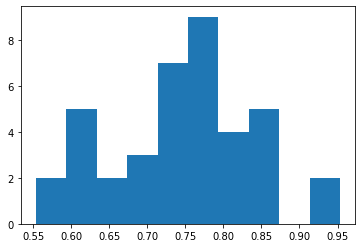

In [34]:
acc=[acc_dct[k][1] for k in acc_dct.keys()]
np.mean(acc)
plt.hist(acc)